<a href="https://colab.research.google.com/github/abuzarmahmood/pymcon_bayesian_changepoint/blob/master/Bayesian_Changepoint_Zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [231]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Execute only if executing in Google Colab
if IN_COLAB:
    !pip install --upgrade pip
    !pip install --upgrade pymc==5.9.0 numpyro==0.13.2
    !git clone https://github.com/abuzarmahmood/pymcon_bayesian_changepoint.git
    !mv pymcon_bayesian_changepoint/src .

In [232]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
import pandas as pd
import numpy as np
import os
import pymc as pm
import pylab as plt
from scipy import stats
import pytensor.tensor as tt
import seaborn as sns
import multiprocessing

In [234]:
from src import get_data, gen_plots

# ==== Prelude ====

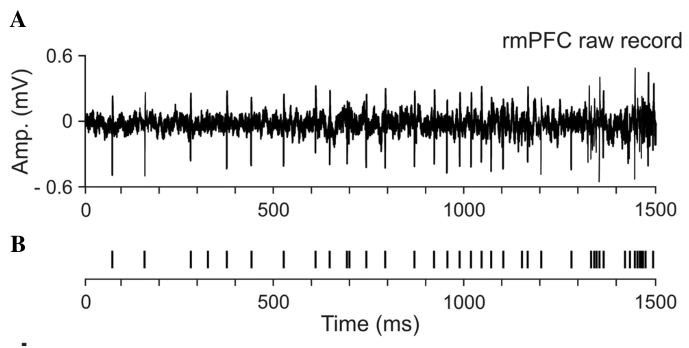

**REF**: Fig. 2, Caro-Martín, C.R., Delgado-García, J.M., Gruart, A. et al. Spike sorting based on shape, phase, and distribution features, and K-TOPS clustering with validity and error indices. Sci Rep 8, 17796 (2018). https://doi.org/10.1038/s41598-018-35491-4

- If you record voltage from the brain, neurons show sharp "spikes" in their activity when they are active/on (**panel A**)
- Many neurons display reliable patterns of activity in response to an event or stimulus (e.g. sugar water on the tongue, or seeing a specific object).
- To visualize these patterns of activity, we can denote the times at which the neuron is active in a "spike train" (**panel B**). This is a timeseries of binary values indicating when the neuron was active.
- Analyzing the dynamics of the spike trains can inform us about which brain regions are active for a specific process (e.g. processing taste), and at what times.

# ==== Load Data ====

- We will load data from an extracellular recording from the Gustatory Cortex (see **REF** below) involving 30 repeated deliveries of a single taste (30 trials), 29 simultanesouly recorded neurons, and 7000ms of spike trains around the time of taste delivery (2000ms before, and 5000ms after).
- We will also load an estimate of the instantaneous emission rate, purely for visualization.

- **REF**: Katz, D. B., et al. “Dynamic and Multimodal Responses of Gustatory Cortical Neurons in Awake Rats.” The Journal of Neuroscience: The Official Journal of the Society for Neuroscience, vol. 21, no. 12, June 2001, pp. 4478–89. PubMed, https://doi.org/10.1523/JNEUROSCI.21-12-04478.2001.

In [235]:
# Binned spike trains (spike counts)
spike_dat = np.load(os.path.join('data/binned_spikes.npy'))

In [236]:
print(f'{spike_dat.shape} = (Trials, Neurons, Time)')

(30, 7, 20) = (Trials, Neurons, Time)


(120, 15, 40)


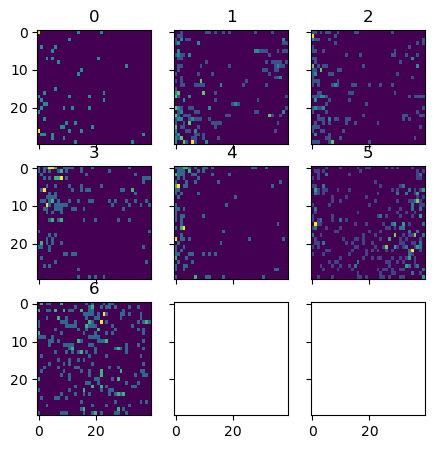

In [451]:
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize
data_dir = '/media/fastdata/VF350_SUC1_190327_121132_repacked/'
dat = ephys_data(data_dir)
dat.get_spikes()
data_vec = np.squeeze(np.array(dat.spikes))
#data_vec = spikes[np.where(lasers)[0]]
time_lims = [2000,4000]
data_vec = data_vec[...,time_lims[0]:time_lims[1]]
bin_width = 50
spike_array = np.sum(np.reshape(data_vec,(*data_vec.shape[:2],-1,bin_width)),axis=-1)
print(spike_array.shape)
wanted_nrn_inds = np.array([0,1,2,4,5,9,13])
spike_array = spike_array[:, wanted_nrn_inds]
# Take alternate trials
spike_array = spike_array[::4]
fig,ax = visualize.gen_square_subplots(spike_array.shape[1], figsize = (5,5), sharex=True, sharey=True);
for ind, (this_dat, this_ax) in enumerate(zip(np.swapaxes(spike_array,0,1), ax.flatten())):
    this_ax.imshow(this_dat, interpolation='nearest', aspect='auto')
    this_ax.set_title(ind)

In [452]:
spike_dat = spike_array

#### Visualize data

Plot spike-trains and firing rates for some neurons

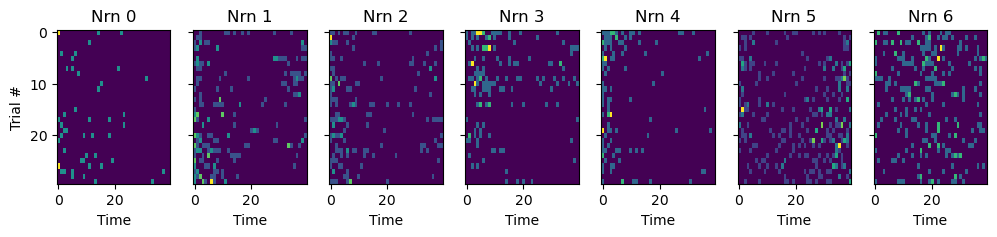

In [454]:
img_kwargs = dict(interpolation = 'nearest', aspect = 'auto')

fig,ax = plt.subplots(1, 
                      spike_dat.shape[1], 
                      figsize = (12,2), 
                      sharex=True, sharey=True
                     );
for ind, (this_dat, this_ax) in enumerate(zip(np.swapaxes(spike_dat,0,1), ax.flatten())):
    this_ax.imshow(this_dat, **img_kwargs)
    this_ax.set_title(f'Nrn {ind}');
    this_ax.set_xlabel('Time');
ax[0].set_ylabel('Trial #');

# === Single Poisson Multivariate Changepoint ===

- We first analyze spike-trains using a single-changepoint model to see when changes occur.
- We will infer when changes in the neural activity happen on-average, averaging across trials.

Parent example: </br>
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC_current.ipynb

#### Get, and plot data

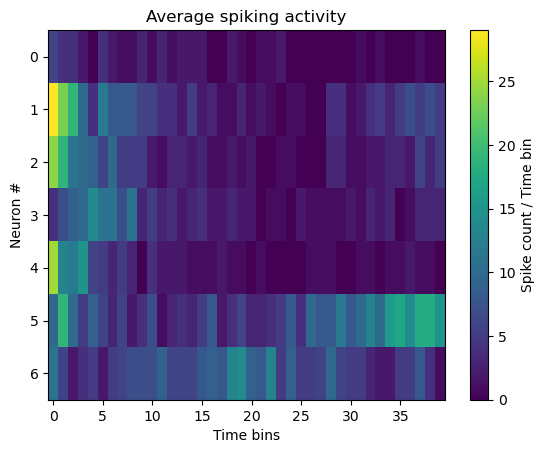

In [476]:
sum_spikes = spike_dat.sum(axis=0)

plt.imshow(sum_spikes, **img_kwargs);
plt.xlabel('Time bins');
plt.ylabel('Neuron #');
plt.title('Average spiking activity');
plt.colorbar(label = 'Spike count / Time bin');

#### Construct simple Poisson Model

In [477]:
n_nrn, n_time_bins = sum_spikes.shape
n_states = 4
idx = np.arange(n_time_bins)

with pm.Model() as simple_model:

    # Emission rates
    lambda_latent = pm.Exponential('lambda_latent', 
                                   0.1,
                                   shape = (n_nrn, n_states))

    # Changepoint position
    tau_latent = pm.Beta(
        'tau_latent', 1, 1,
        shape = (n_states-1),
    ).sort(axis=-1)
    
    tau = pm.Deterministic('tau',
            idx.min() + (idx.max() - idx.min()) * tau_latent,
            )

    # Generate weight stack
    forward_stack = tt.math.sigmoid(
        idx[np.newaxis, :]-tau[:, np.newaxis])
    forward_stack = tt.concatenate(
        [np.ones((1, n_time_bins)), forward_stack], axis=0)

    inverse_stack = 1 - forward_stack[1:]
    inverse_stack = tt.concatenate(
        [inverse_stack, np.ones((1, n_time_bins))], axis=0)

    weight_stack = np.multiply(forward_stack, inverse_stack)

    # Neurons x Time
    lambda_ = tt.tensordot(     
        lambda_latent,  # neurons x states
        weight_stack, # states x time
        axes = (1,0)
    )
        
    observation = pm.Poisson("obs", lambda_, observed=sum_spikes)

Text(0.5, 0, 'Time Bin')

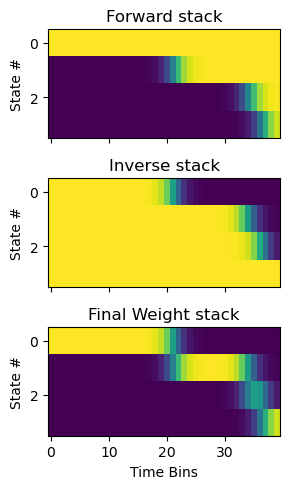

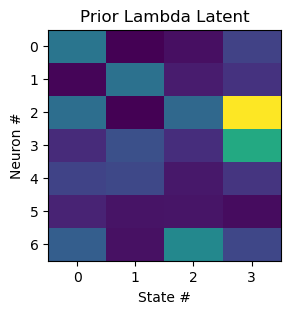

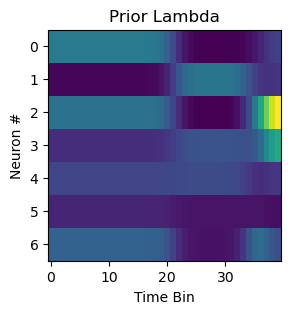

In [478]:
fig,ax = plt.subplots(3,1, sharex=True, figsize = (3,5))
ax[0].imshow(forward_stack.eval(), **img_kwargs)
ax[0].set_title('Forward stack')


ax[1].imshow(inverse_stack.eval(), **img_kwargs)
ax[1].set_title('Inverse stack')


ax[2].imshow(weight_stack.eval(), **img_kwargs)
ax[2].set_title('Final Weight stack')
for this_ax in ax:
    this_ax.set_ylabel('State #')
ax[-1].set_xlabel('Time Bins')
plt.tight_layout()

plt.figure(figsize= (3,3))
plt.imshow(lambda_latent.eval(), **img_kwargs);
plt.title('Prior Lambda Latent')
plt.xlabel('State #')
plt.ylabel('Neuron #')

plt.figure(figsize= (3,3))
plt.imshow(lambda_.eval(), **img_kwargs);
plt.title('Prior Lambda')
plt.ylabel('Neuron #')
plt.xlabel('Time Bin')

Sampling: [lambda_latent, obs, tau_latent]


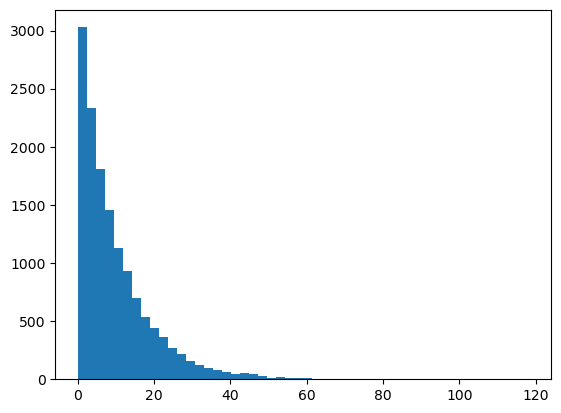

In [479]:
with simple_model:
    prior_pred = pm.sample_prior_predictive()

lambda_prior = prior_pred['prior']['lambda_latent'].values
plt.hist(lambda_prior.flatten(), 50);

Text(0, 0.5, 'Tau 2')

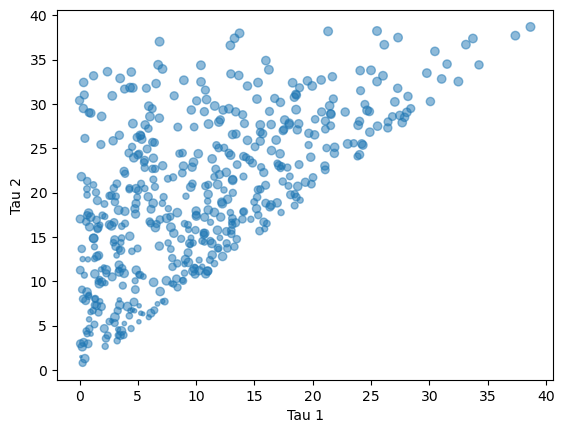

In [480]:
plt.scatter(*np.squeeze(prior_pred['prior']['tau']).T, alpha = 0.5)
plt.xlabel('Tau 1')
plt.ylabel('Tau 2')

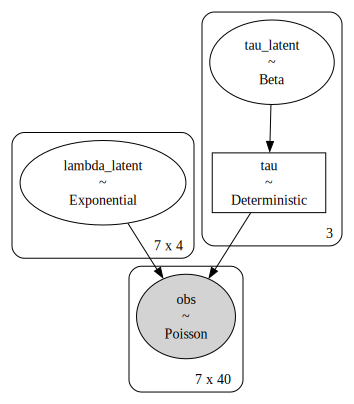

In [481]:
# Plot the graph for the model
pm.model_to_graphviz(simple_model)

In [482]:
# Run inference on the model
with simple_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_latent, tau_latent]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


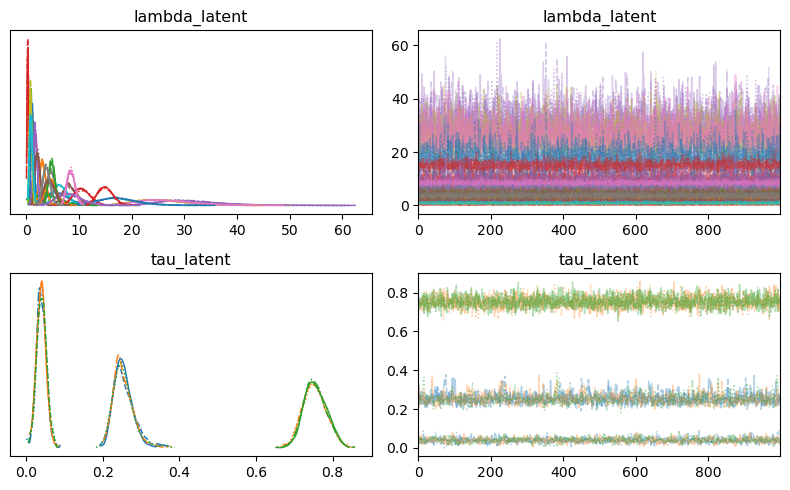

In [483]:
# Plot inferred distributions
ax = pm.plot_trace(trace, figsize = (8,5), var_names = ['lambda_latent','tau_latent']);
plt.tight_layout()

Sampling: [obs]


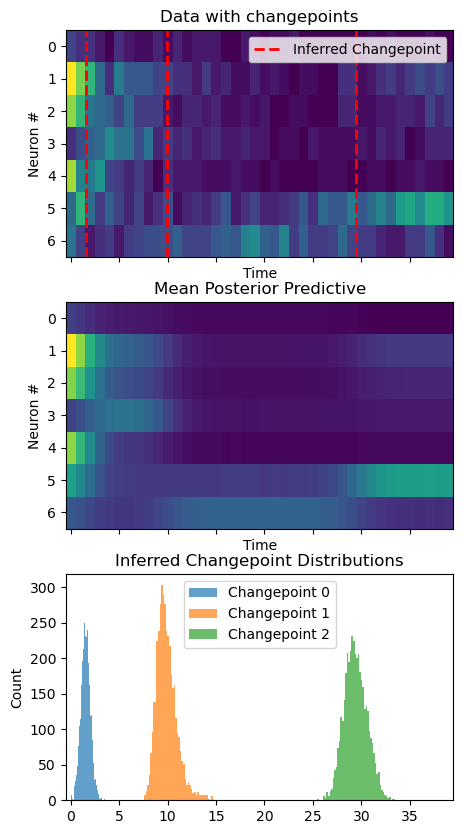

In [484]:
figsize = (5,10)
years = idx

with simple_model:
    poisson_ppc = pm.sample_posterior_predictive(trace)

    ppc_values = poisson_ppc['posterior_predictive']['obs']
    mean_ppc, std_ppc = np.mean(ppc_values,axis=(0,1)),np.std(ppc_values,axis=(0,1))

    poisson_switch_inferred = trace["posterior"]["tau"].values

    mean_switch = poisson_switch_inferred.mean(axis=(0,1)) 
    std_switch = poisson_switch_inferred.std(axis=(0,1))
    
    fig, ax = plt.subplots(3,1,figsize=figsize, sharex=True)
    ax[0].imshow(sum_spikes,aspect='auto')
    ax[0].set_ylabel("Neuron #") 
    ax[0].set_xlabel("Time") 
    ax[0].set_title('Data with changepoints')

    for num, this_val in enumerate(mean_switch):
        if num == 0:
            ax[0].axvline(this_val,
                       color="red", linewidth = 2, 
                          linestyle = '--', label = 'Inferred Changepoint')
        else:
            ax[0].axvline(this_val,
                       color="red", linewidth = 2, 
                          linestyle = '--',)
    ax[0].legend()

    ax[1].imshow(mean_ppc, aspect='auto')
    ax[1].set_title('Mean Posterior Predictive')
    ax[1].set_ylabel("Neuron #") 
    ax[1].set_xlabel("Time") 

    for num, change in enumerate(poisson_switch_inferred.T):
        ax[2].hist(change.flatten(), 
                   bins = 50, alpha = 0.7,
                  label = f'Changepoint {num}')
    ax[2].legend()
    ax[2].set_title('Inferred Changepoint Distributions')
    ax[2].set_ylabel("Count") 
    ax[1].set_xlabel("Time") 

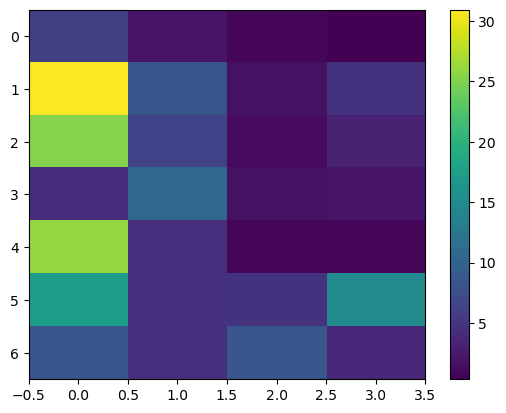

In [485]:
lambda_latent_inferred = trace["posterior"]["lambda_latent"].values
mean_lambda_latent = lambda_latent_inferred.mean(axis=(0,1))

plt.imshow(mean_lambda_latent, aspect='auto');
plt.colorbar()

# === Dirichlet Process Changepoint ===

Related reading: https://medium.com/@abuzar_mahmood/probabilistically-determining-the-number-of-components-for-unsupervised-learning-e1c3c4a82082

In [491]:
def stick_breaking(beta):
    portion_remaining = pm.math.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [492]:
# Index vector timebins in data
n_nrn, n_time_bins = sum_spikes.shape
idx = np.arange(n_time_bins)
max_states = 10

with pm.Model() as dpp_model:

    # ===================
    # Emissions Variables
    # ===================
    lambda_latent = pm.Normal('lambda',
                    mu = 0, sigma = 10,
                    shape = (n_nrn, max_states))

    # =====================
    # Changepoint Variables
    # =====================

    # Hyperpriors on alpha
    a_gamma = pm.Gamma('a_gamma',10,1)
    b_gamma = pm.Gamma('b_gamma',1.5,1)

    # Concentration parameter for beta
    alpha = pm.Gamma('alpha', a_gamma, b_gamma)

    # Draw beta's to calculate stick lengths
    beta = pm.Beta('beta', 1, alpha, shape = max_states)

    # Calculate stick lengths using stick_breaking process
    w_raw = pm.Deterministic('w_raw', stick_breaking(beta))

    # Make sure lengths add to 1, and scale to length of data
    w_latent = pm.Deterministic('w_latent', w_raw / w_raw.sum())
    tau = pm.Deterministic('tau', tt.cumsum(w_latent * n_time_bins)[:-1])

    # Weight stack to assign lambda's to point in time
    weight_stack = pm.math.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = pm.math.concatenate([np.ones((1,n_time_bins)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = pm.math.concatenate([inverse_stack, np.ones((1,n_time_bins))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)

    # Create timeseries for latent variable (mean emission)
    lambda_ = pm.Deterministic('lambda_',
                               tt.tensordot(
                                   lambda_latent,
                                   weight_stack,
                                   axes=(1,0)
                               )
                              )

    # Likelihood for observations
    observation = pm.Normal("obs", mu = lambda_, sigma = 0.1, observed=sum_spikes)

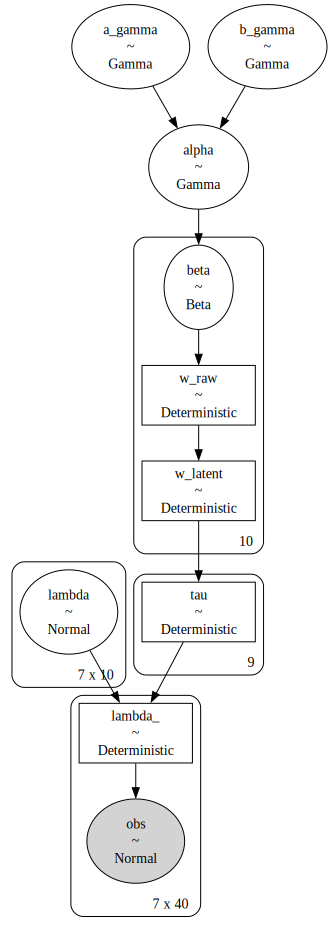

In [493]:
pm.model_to_graphviz(dpp_model)

In [507]:
n_chains = 50
n_samples = 10000
samples_per_chain = n_samples // n_chains

with dpp_model:
    dpp_trace = pm.sample(
                        nuts_sampler="numpyro",
                        tune = samples_per_chain,
                        draws = samples_per_chain,
                        target_accept = 0.95,
                        chains = n_chains,
                        cores = multiprocessing.cpu_count()
                        )

Only 200 samples in chain.


Compiling...
Compilation time =  0:00:27.895580
Sampling...


Compiling.. :   0%|                                                                        | 0/400 [00:00<?, ?it/s]

  0%|                                                                                      | 0/400 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                        | 0/400 [00:00<?, ?it/s]


  0%|                                                                                      | 0/400 [00:00<?, ?it/s]


Compiling.. :   0%|                                                                        | 0/400 [00:00<?, ?it/s]



  0%|                                                                                      | 0/400 [00:00<?, ?it/s]



Compiling.. :   0%|                                                                        | 0/400 [00:00<?, ?it/s]




  0%|                                                                                      | 0/400 [00:00<?, ?it/s]




Compiling.. :   0%|                                 

Sampling time =  0:00:16.110788
Transforming variables...
Transformation time =  0:00:00.633441


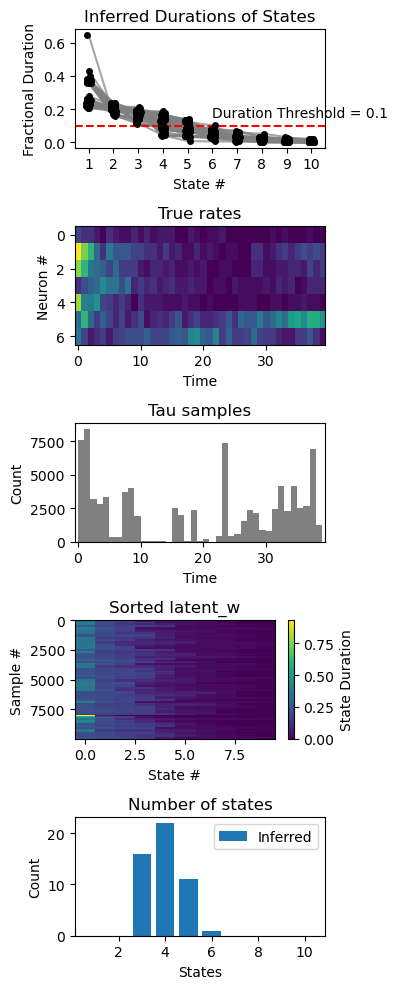

In [510]:
gen_plots.gen_dirichlet_plots(dpp_trace, sum_spikes, n_chains, n_time_bins, max_states, 
                              n_states = None, dur_thresh = 0.1, figsize = (4,10))

In [558]:
mean_w_latent = dpp_trace['posterior']['w_latent'].values.mean(axis=1)
thresh_vec = np.linspace(0.01, 0.2)

state_bins = np.arange(10)+0.5
thresh_counts = []
for this_thresh in thresh_vec:
    this_counts = (mean_w_latent > this_thresh).sum(axis=-1)
    thresh_counts.append(this_counts)

median_counts = np.array([np.median(x) for x in thresh_counts])
count_frame = pd.concat([pd.DataFrame(data = dict(thresh = this_thresh, counts = this_count)) \
                        for this_thresh, this_count in zip(thresh_vec, thresh_counts)])

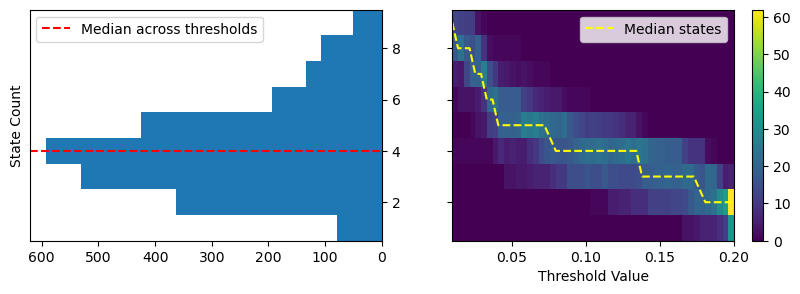

In [559]:
fig, ax = plt.subplots(1,2, sharey=True, figsize = (10,3))
im = ax[1].hist2d(*count_frame.values.T, bins = [thresh_vec, state_bins]);
ax[1].plot(thresh_vec, median_counts, color = 'yellow', linestyle = '--', label = "Median states");
ax[1].set_xlabel('Threshold Value');
ax[0].set_ylabel('State Count');
ax[1].legend()
plt.colorbar(im[3], ax=ax[1])
ax[0].hist(count_frame['counts'], bins = state_bins, orientation = 'horizontal');
ax[0].set_xlim(ax[0].get_xlim()[::-1])
ax[0].yaxis.tick_right()
ax[0].axhline(np.median(count_frame['counts']), color = 'red', linestyle = '--', label = 'Median across thresholds');
ax[0].legend();

# === Bernoulli Mixture Emissions ===

- The "on-average" picture above assumes that we can average across all trials and get a good picture of the data. While this is true in most cases, in many cases, data for all trials DO NOT belong to the same set (see **REF** below).
- In such cases, we need to account for this inhomogeneity and treat these sets of trials differently, else, our model will likely perform poorly (see **Related Reading** below).
- This would be easy if we knew what the different trials were, but in many cases, we don't have any a-priori knowledge about which trials may be different.
- Hence, a principled way to address this issue is to use a changepoint model with a mixture of emissions. 

- **REF** : Humphries, Mark D. “Spike-Train Communities: Finding Groups of Similar Spike Trains.” Journal of Neuroscience, vol. 31, no. 6, Feb. 2011, pp. 2321–36. www.jneurosci.org, https://doi.org/10.1523/JNEUROSCI.2853-10.2011.
- **Related Reading**: https://medium.com/@abuzar_mahmood/changepoint-detection-for-inhomogeneous-timeseries-mixture-emissions-in-pymc3-2301f76c0064

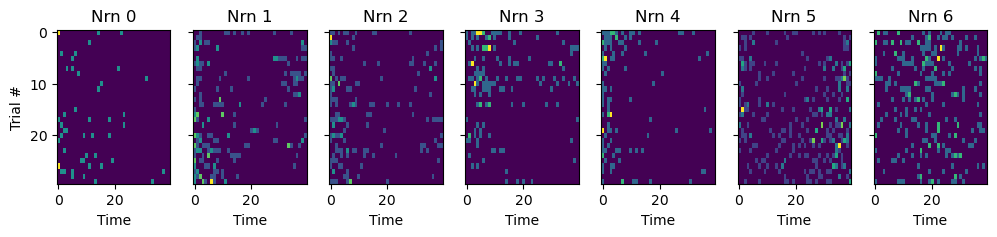

In [496]:
fig,ax = plt.subplots(1, 
                      spike_dat.shape[1], 
                      figsize = (12,2), 
                      sharex=True, sharey=True
                     );
for ind, (this_dat, this_ax) in enumerate(zip(np.swapaxes(spike_dat,0,1), ax.flatten())):
    this_ax.imshow(this_dat, interpolation='nearest', aspect='auto')
    this_ax.set_title(f'Nrn {ind}');
    this_ax.set_xlabel('Time');
ax[0].set_ylabel('Trial #');

- In the plots above, we can see changes across both time, and across trials.
- **Roughly, trials after #15 exhibit higher emission rates from 2000-4000ms than earlier trials.**
- This means that if we fit a changepoint model for multiple trials, we can not assume constant emissions.

In [497]:
n_trials, nrn_num, time_bins = spike_dat.shape
n_components = 2
n_states = 3


# Generate initvals for emission rates
# ======================================
# Average across sets of trials
mean_firing = np.stack(
    np.array_split(spike_dat, n_components, axis=0)).mean(axis=1)
# Average across time
mean_firing = np.array_split(mean_firing, n_states, axis=2)
mean_firing = np.stack([x.mean(axis=-1) for x in mean_firing])


with pm.Model() as model:

    alpha_w = pm.Gamma('alpha_w',7.5,1,shape = n_components)
    # trials x n_components
    w = pm.Dirichlet('w', a=alpha_w, shape = (n_trials,n_components))

    # Define Emissions

    # nrns
    nrn_lambda = pm.Exponential('nrn_lambda', 100, shape=(nrn_num))

    # nrns x switch_comps
    trial_lambda = pm.Exponential('comp_lambda',
                                  nrn_lambda.dimshuffle(0, 'x'),
                                  shape=(nrn_num, n_components))

    # nrns x n_components x n_states
    state_lambda = pm.Exponential('state_lambda',
                                  trial_lambda.dimshuffle(0, 1, 'x'),
                                  initval = mean_firing.T,
                                  shape=(nrn_num, n_components, n_states))

     # Define Changepoints
    # Assuming distribution of changepoints remains
    # the same across all trials

    a = pm.HalfCauchy('a_tau', 3., shape=n_states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape=n_states - 1)

    tau_latent = pm.Beta('tau_latent', a, b,
                         shape=(n_trials, n_states-1))

    # # Trials x Changepoints
    tau = pm.Deterministic('tau', time_bins * tau_latent)

    #################################################
    
    # Then, we can select state_emissions for every trial
    idx = np.arange(time_bins)

    # tau : Trials x Changepoints
    weight_stack = pm.math.sigmoid(
        idx[np.newaxis, :]-tau[:, :, np.newaxis])
    weight_stack = tt.concatenate(
        [np.ones((n_trials, 1, time_bins)), weight_stack], axis=1)
    inverse_stack = 1 - weight_stack[:, 1:]
    inverse_stack = tt.concatenate(
        [inverse_stack, np.ones((n_trials, 1, time_bins))], axis=1)

    # Trials x n_states x Time
    weight_stack = np.multiply(weight_stack, inverse_stack)

    #################################################
    # Trials x neurons x n_states
    selected_lambdas = pm.Deterministic(
        'selected_lambdas', 
        tt.math.tensordot(w,state_lambda, axes=(1,1)))

    # trials x neurons x time
    lambda_ = tt.sum(
        # trials x n_states x neurons x None        # trials n_states x None x time
        selected_lambdas.dimshuffle(0, 2, 1, 'x') * weight_stack.dimshuffle(0, 1, 'x', 2),
                     axis=1)

    # Add observations
    observation = pm.Poisson("obs", lambda_, observed=spike_dat)

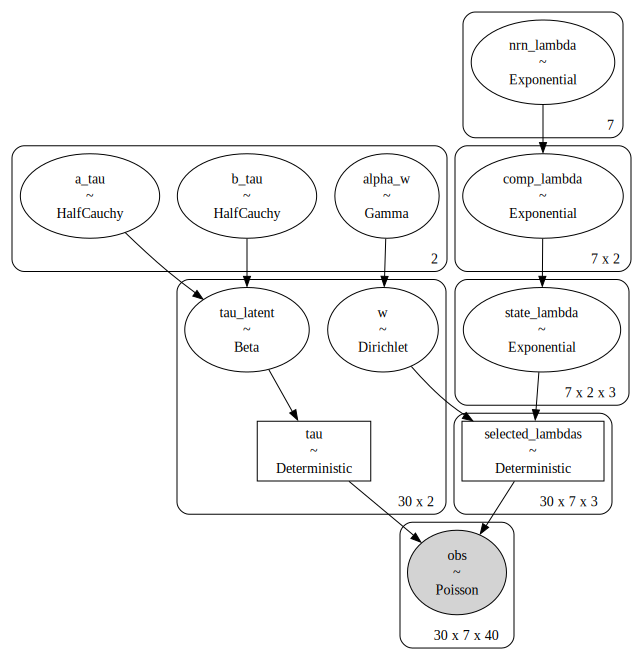

In [564]:
pm.model_to_graphviz(model)

In [499]:
with model:
    trace = pm.sample(nuts_sampler="numpyro", chains = 4, cores = 4)

Compiling...
Compilation time =  0:00:04.288296
Sampling...


Compiling.. :   0%|                                                                       | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                     | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                       | 0/2000 [00:00<?, ?it/s]


  0%|                                                                                     | 0/2000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                                    | 0/2000 [00:06<?, ?it/s]


Running chain 3:   0%|                                                                    | 0/2000 [00:06<?, ?it/s]

Running chain 1:   5%|██▉                                                       | 100/2000 [00:14<02:43, 11.59it/s]


Running chain 3:   5%|██▉                                                       | 100/2000 [00:15<03:04, 10.29it/s]

Running chain 1:  10%|█████▊                                

Sampling time =  0:02:18.793126
Transforming variables...
Transformation time =  0:00:00.380669


In [500]:
selected_lambdas_post = trace['posterior']['selected_lambdas'].values
w_post = trace['posterior']['w'].values

mean_selected_lambdas = selected_lambdas_post.mean(axis=(0,1))
mean_w = w_post.mean(axis=(1))

nrn_mean_lambdas = np.swapaxes(mean_selected_lambdas, 0,1)

In [565]:
mean_w.shape

(4, 30, 2)

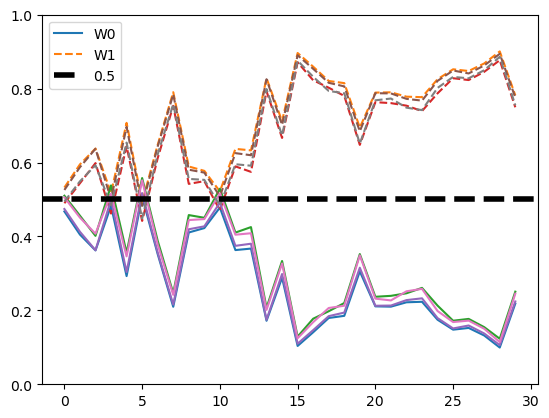

In [570]:
for ind, chain in enumerate(mean_w):
    if ind == 0:
        labels = ['W0','W1']
    else:
        labels = [None, None]
    plt.plot(chain[:,0], label = labels[0])
    plt.plot(chain[:,1], linestyle = '--', label = labels[1])
plt.ylim(0,1)
plt.axhline(0.5, linestyle = '--', label = '0.5', color = 'k', linewidth = 4)
plt.legend()

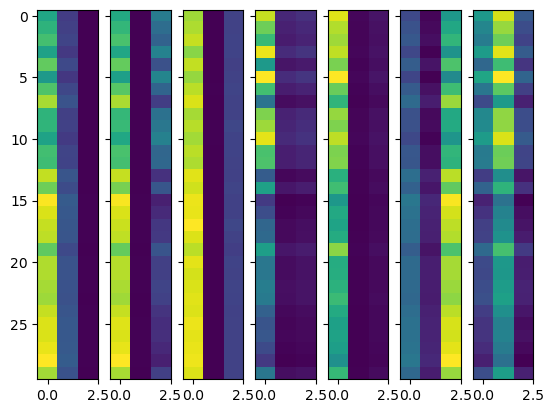

In [502]:
fig, ax = plt.subplots(1, len(nrn_mean_lambdas), sharex=True, sharey=True)
for this_ax, this_dat in zip(ax, nrn_mean_lambdas):
    this_ax.imshow(this_dat, aspect='auto')

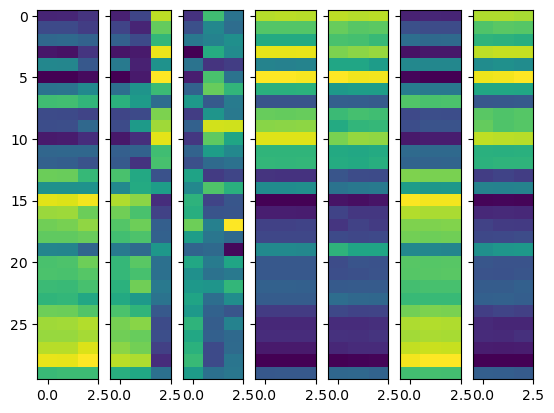

In [503]:
fig, ax = plt.subplots(1, len(nrn_mean_lambdas), sharex=True, sharey=True)
for this_ax, this_dat in zip(ax, nrn_mean_lambdas):
    this_ax.imshow(stats.zscore(this_dat,axis=0), aspect='auto')

In [504]:
tau_stack = trace['posterior']['tau'].values
int_tau = np.vectorize(int)(tau_stack)
mode_tau = np.squeeze(stats.mode(int_tau,axis=(0,1))[0])

Text(0, 0.5, 'Trial Number')

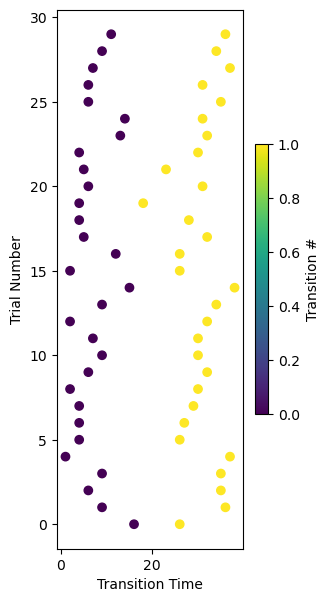

In [505]:
fig,ax = plt.subplots(figsize = (3,7))
for num, vals in enumerate(mode_tau):
    im = ax.scatter(vals,[num]*len(vals), c = range(len(vals)))
plt.colorbar(im, shrink = 0.5, label = 'Transition #')
plt.xlabel('Transition Time')
plt.ylabel('Trial Number')